## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'AC'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-68.4636,-10.8214,287.18,978170.24,978152.810566,17.429434
1,-68.7128,-11.0711,287.60,978135.48,978151.182171,-15.702171
2,-68.6956,-11.1164,293.46,978148.95,978159.410829,-10.460829
3,-67.7467,-10.0092,177.85,978130.89,978157.073159,-26.183159
4,-67.7172,-9.9494,157.61,978144.27,978161.665666,-17.395666
...,...,...,...,...,...,...
154,-67.5208,-10.1867,196.55,978161.83,978160.636236,1.193764
155,-67.3761,-10.1361,215.58,978148.09,978151.148863,-3.058863
156,-67.3258,-10.1803,193.76,978150.79,978157.490425,-6.700425
157,-67.4006,-10.1686,206.59,978151.19,978155.169472,-3.979472


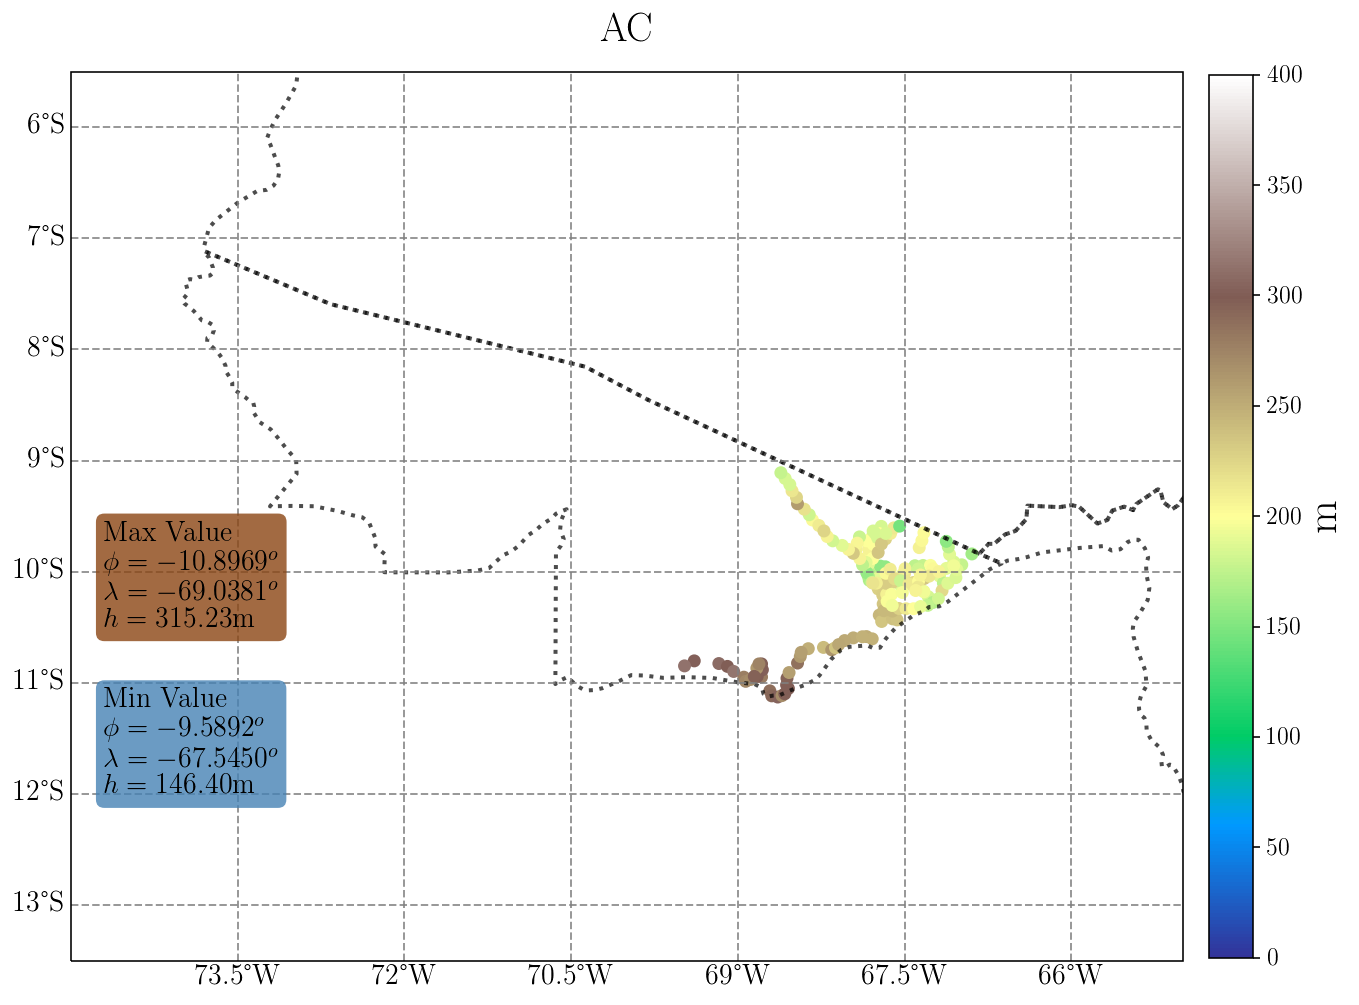

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(12.,14.), region=[-75.,-65.,-13.5,-5.5],\
         cmap='terrain', sign=(-74.7,-74.7,-10.5,-12), shrink=0.58, lim_val=(True,True,0.,400.))

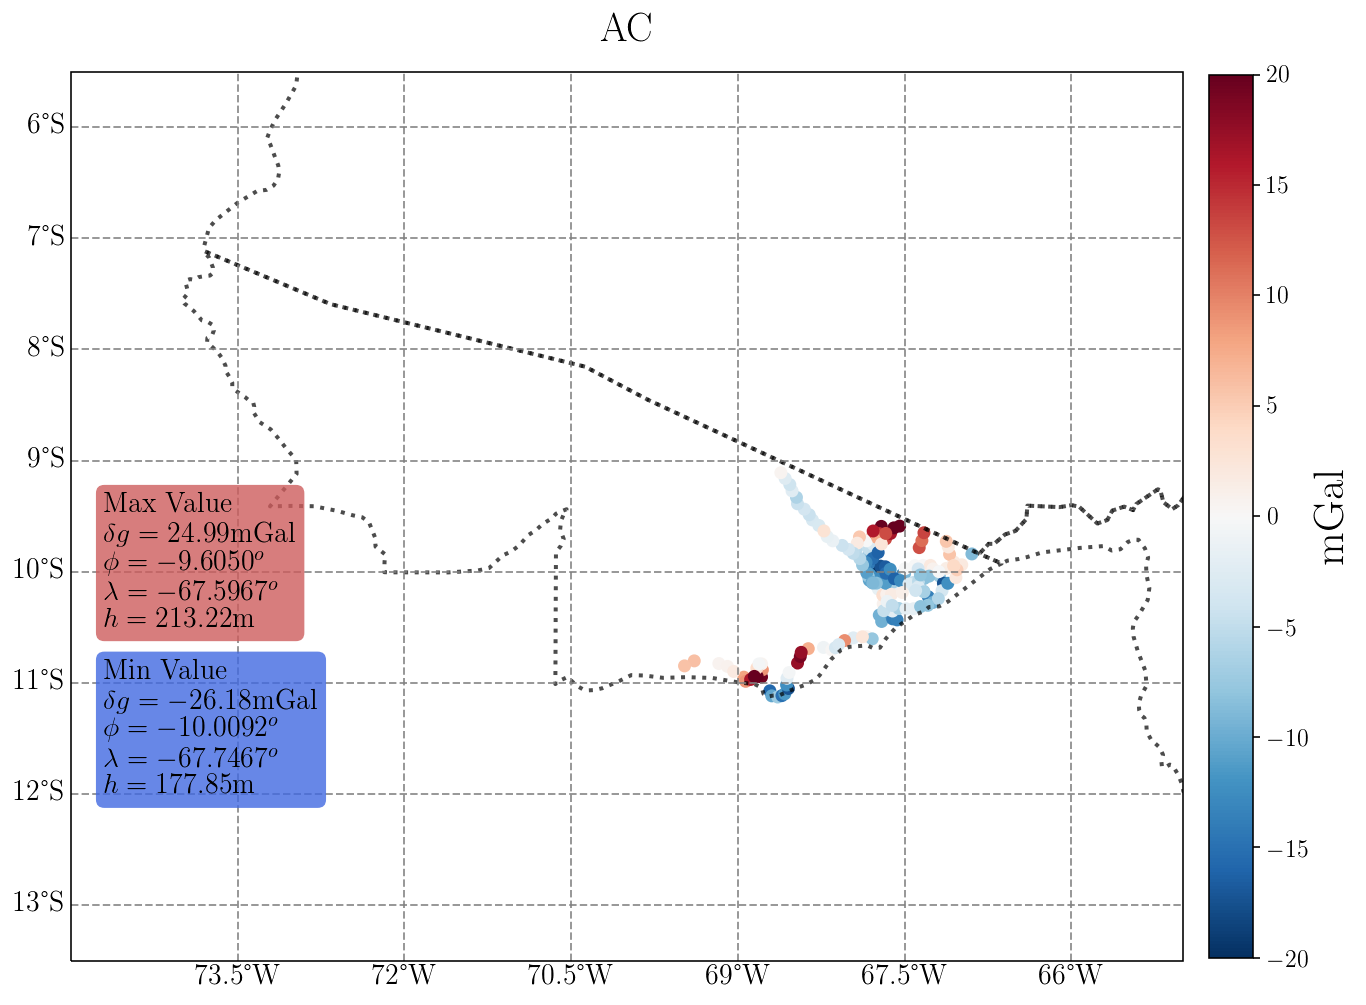

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-75.,-65.,-13.5,-5.5],\
         sign=(-74.7,-74.7,-10.5,-12), shrink=0.58, lim_val=(True, 20.))

### Calculating rotation matrices and Cartesian coordinates

In [8]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))

## Estimating the first set of point-mass parameters

In [9]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [10]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [11]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]

In [12]:
Rcl = R[:, indl]

In [13]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(159, 159)


In [14]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [15]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

159


In [16]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [17]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

1.1870948668502024e-11

In [18]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [19]:
rabs_max.append(rabs_max_l)

In [20]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

1.1870948668502024e-11


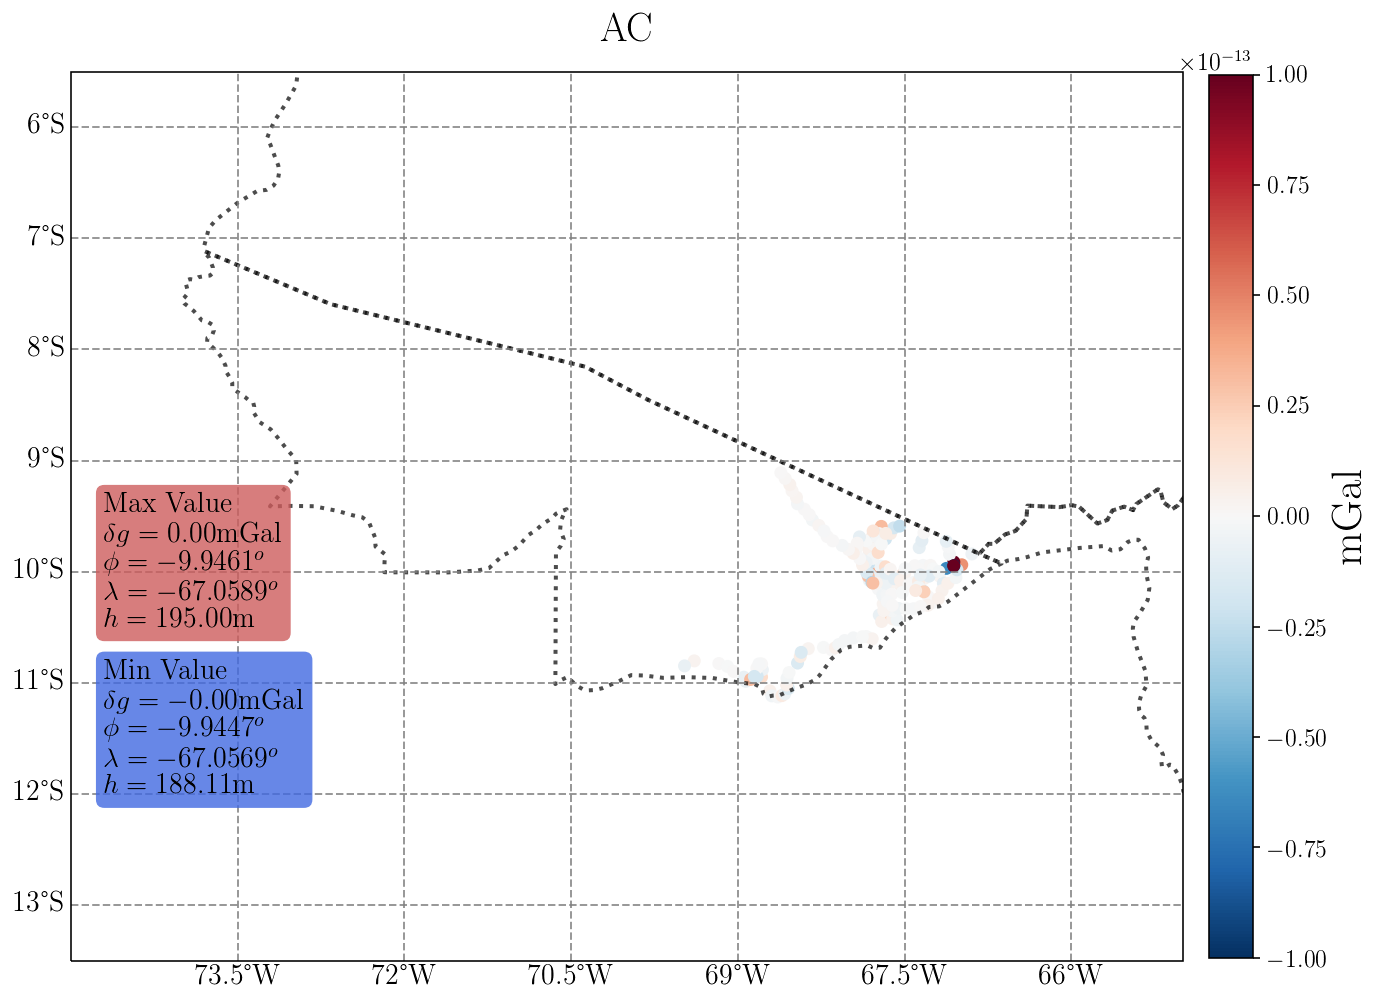

In [21]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(12.,14.), region=[-75.,-65.,-13.5,-5.5],\
         sign=(-74.7,-74.7,-10.5,-12), shrink=0.58, lim_val=(True, 1e-15))

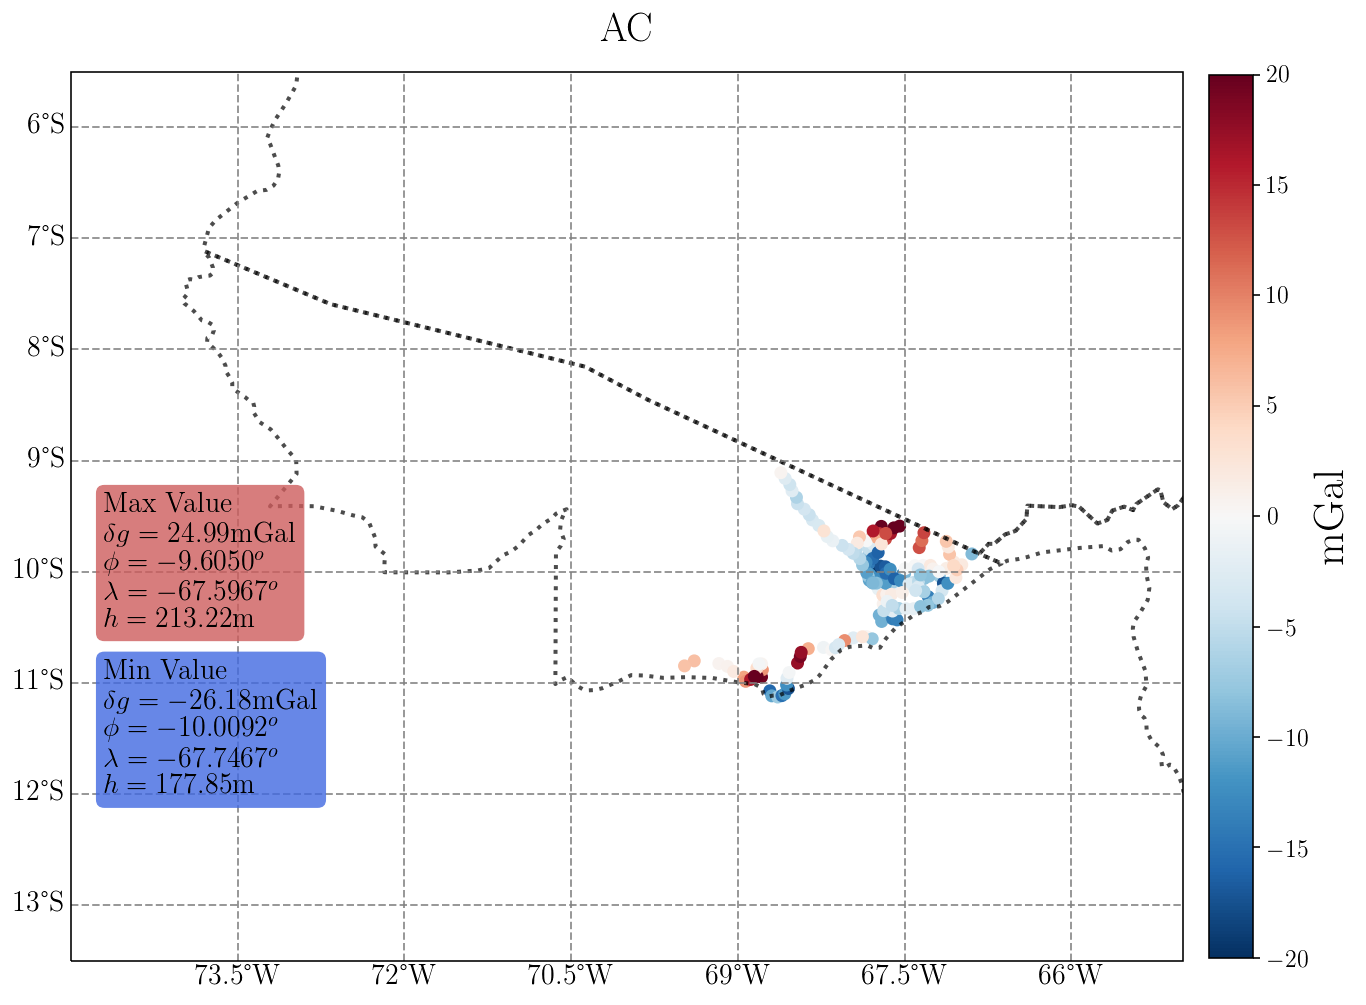

In [22]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-75.,-65.,-13.5,-5.5],\
         sign=(-74.7,-74.7,-10.5,-12), shrink=0.58, lim_val=(True, 20.))

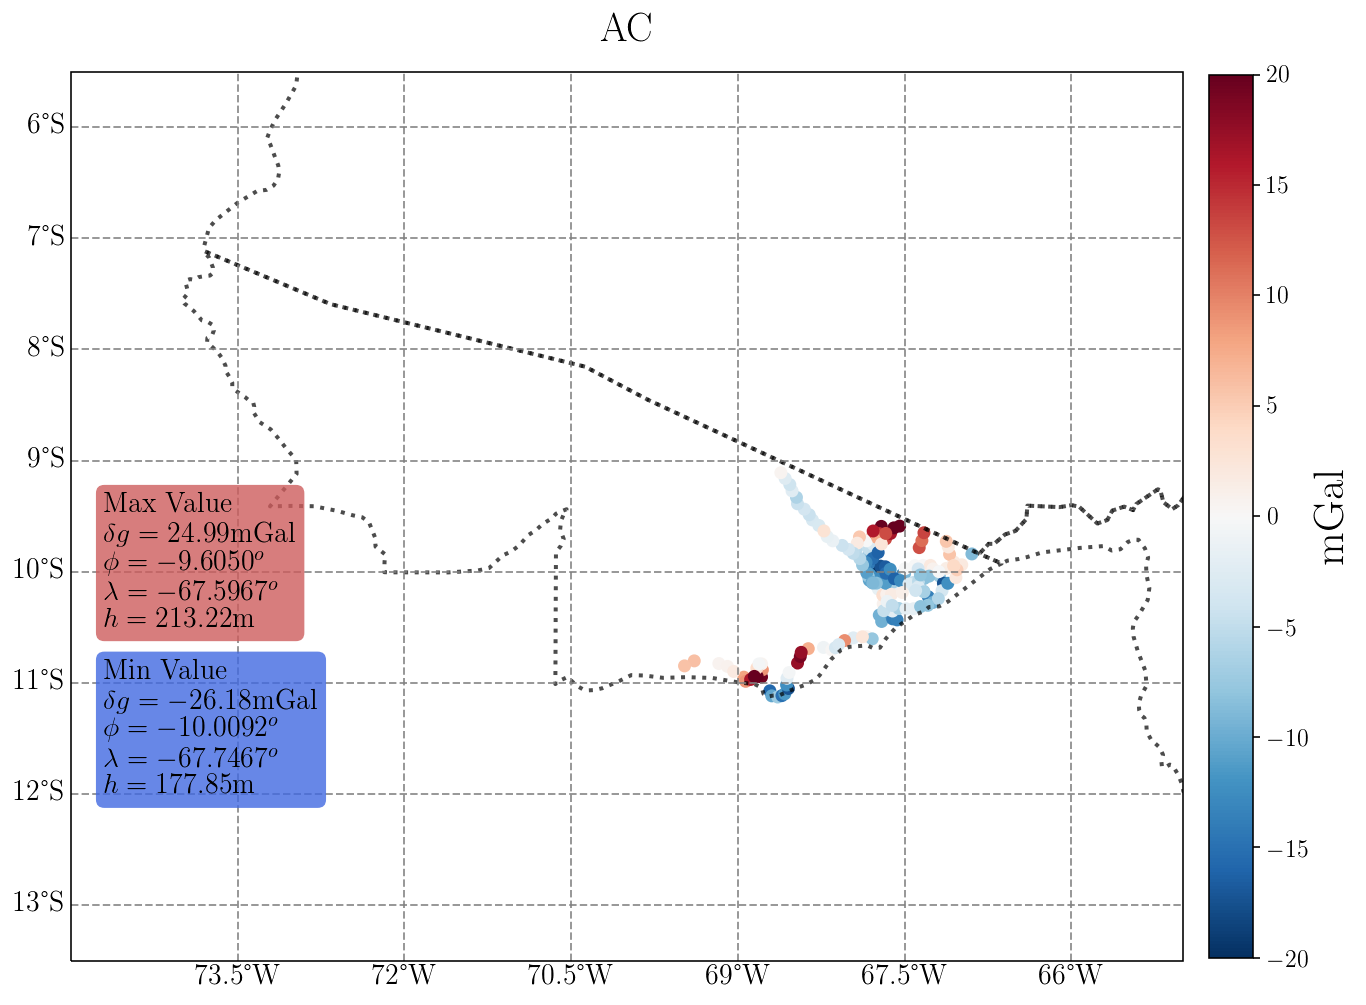

In [23]:
point_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), region=[-75.,-65.,-13.5,-5.5],\
         sign=(-74.7,-74.7,-10.5,-12), shrink=0.58, lim_val=(True, 20.))

In [24]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [25]:
new_data = {'LONG':bdg.LONG.values, \
            'LAT':bdg.LAT.values, \
            'ALT':bdg.ALT_GEOM.values, \
            'BDG':bdg.GRAV.values, \
            'EIGEN':eigen.GRAV.values, \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-68.4636,-10.8214,287.18,978170.24,978152.810566,17.429434,6.214068e+12,-1.421085e-14
1,-68.7128,-11.0711,287.60,978135.48,978151.182171,-15.702171,-5.595992e+12,5.329071e-15
2,-68.6956,-11.1164,293.46,978148.95,978159.410829,-10.460829,-2.970026e+12,-3.552714e-15
3,-67.7467,-10.0092,177.85,978130.89,978157.073159,-26.183159,-8.053851e+12,3.907985e-14
4,-67.7172,-9.9494,157.61,978144.27,978161.665666,-17.395666,-4.429796e+12,-3.552714e-15
...,...,...,...,...,...,...,...,...
154,-67.5208,-10.1867,196.55,978161.83,978160.636236,1.193764,6.801953e+11,-4.440892e-16
155,-67.3761,-10.1361,215.58,978148.09,978151.148863,-3.058863,5.769521e+12,-2.664535e-15
156,-67.3258,-10.1803,193.76,978150.79,978157.490425,-6.700425,9.662629e+11,2.398082e-14
157,-67.4006,-10.1686,206.59,978151.19,978155.169472,-3.979472,-8.611120e+11,8.881784e-15


In [26]:
print(df.RESID.min(), df.RESID.max())

-1.1870948668502024e-11 1.1831868818035218e-11


### Upward Continuation

In [27]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [28]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


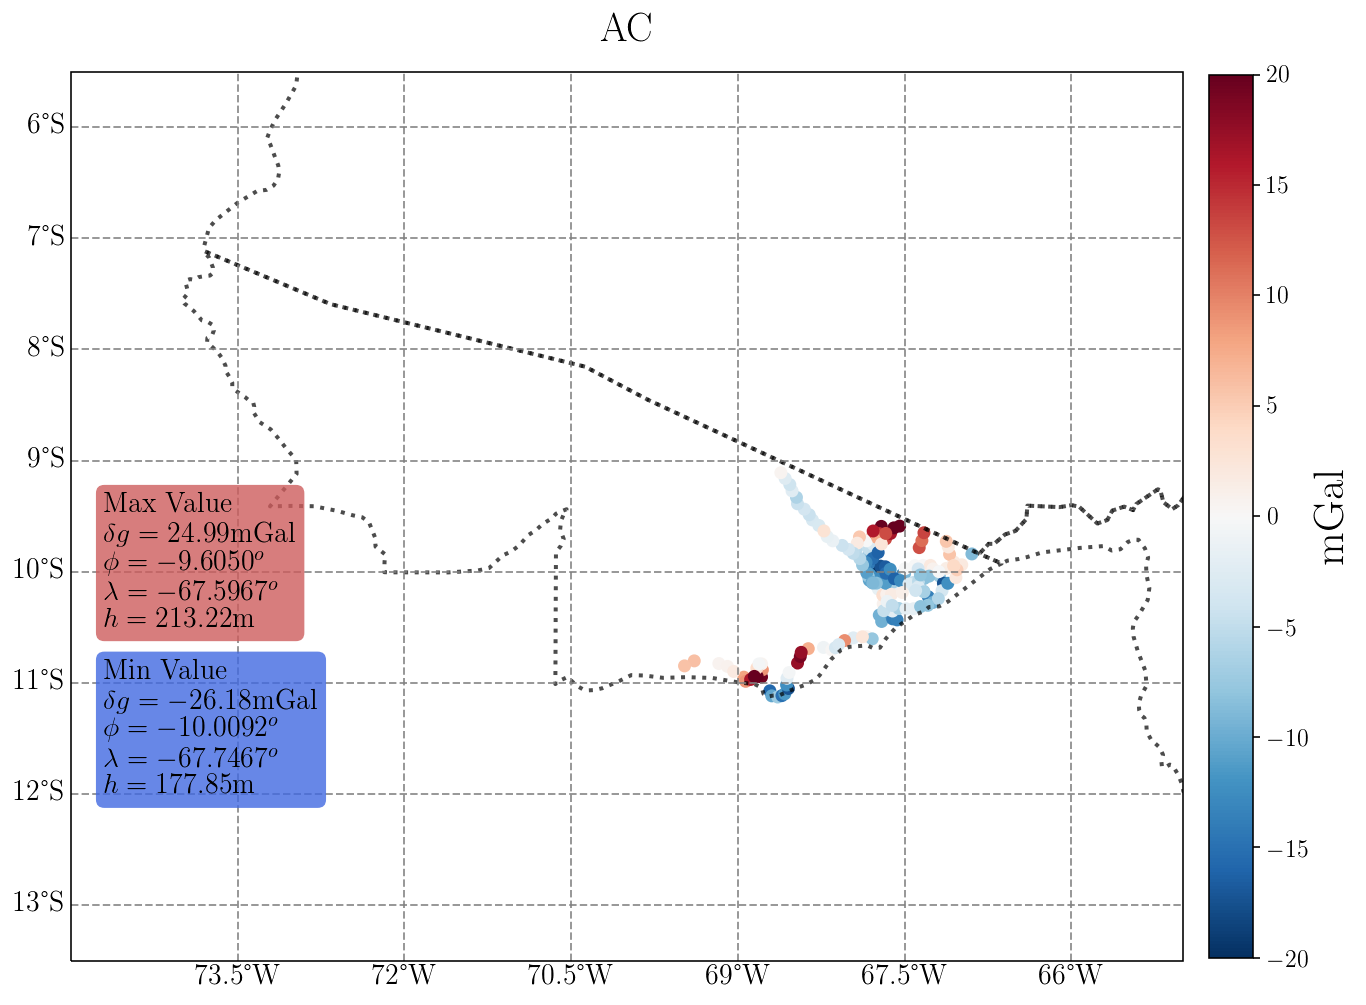

In [29]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-75.,-65.,-13.5,-5.5],\
         sign=(-74.7,-74.7,-10.5,-12), shrink=0.58, lim_val=(True, 20.))

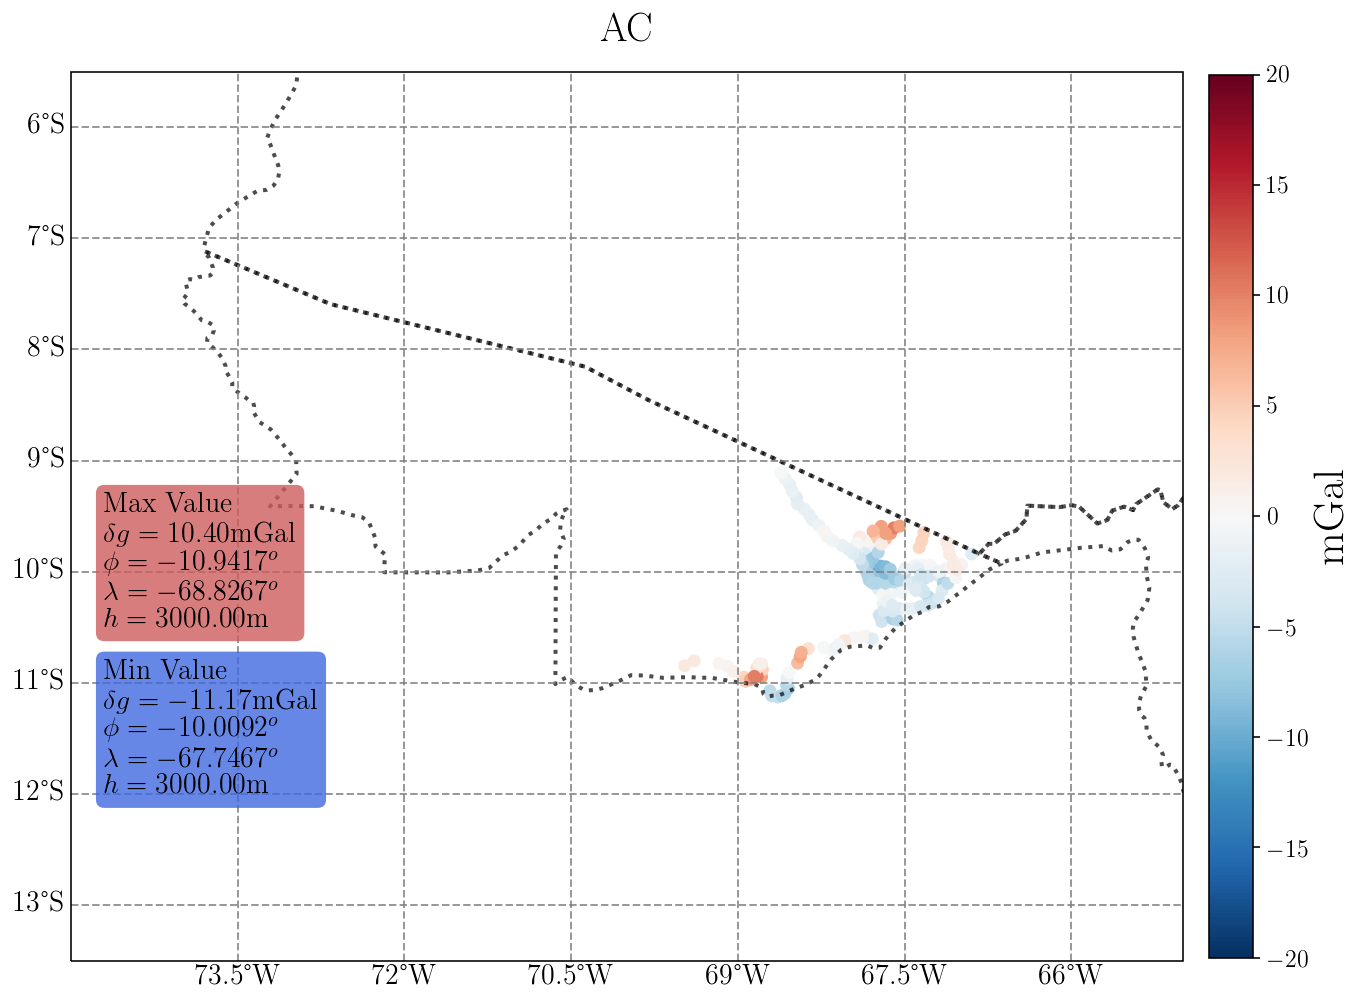

In [30]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(12.,14.), \
          region=[-75.,-65.,-13.5,-5.5], sign=(-74.7,-74.7,-10.5,-12), shrink=0.58, lim_val=(True, 20.))

In [31]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


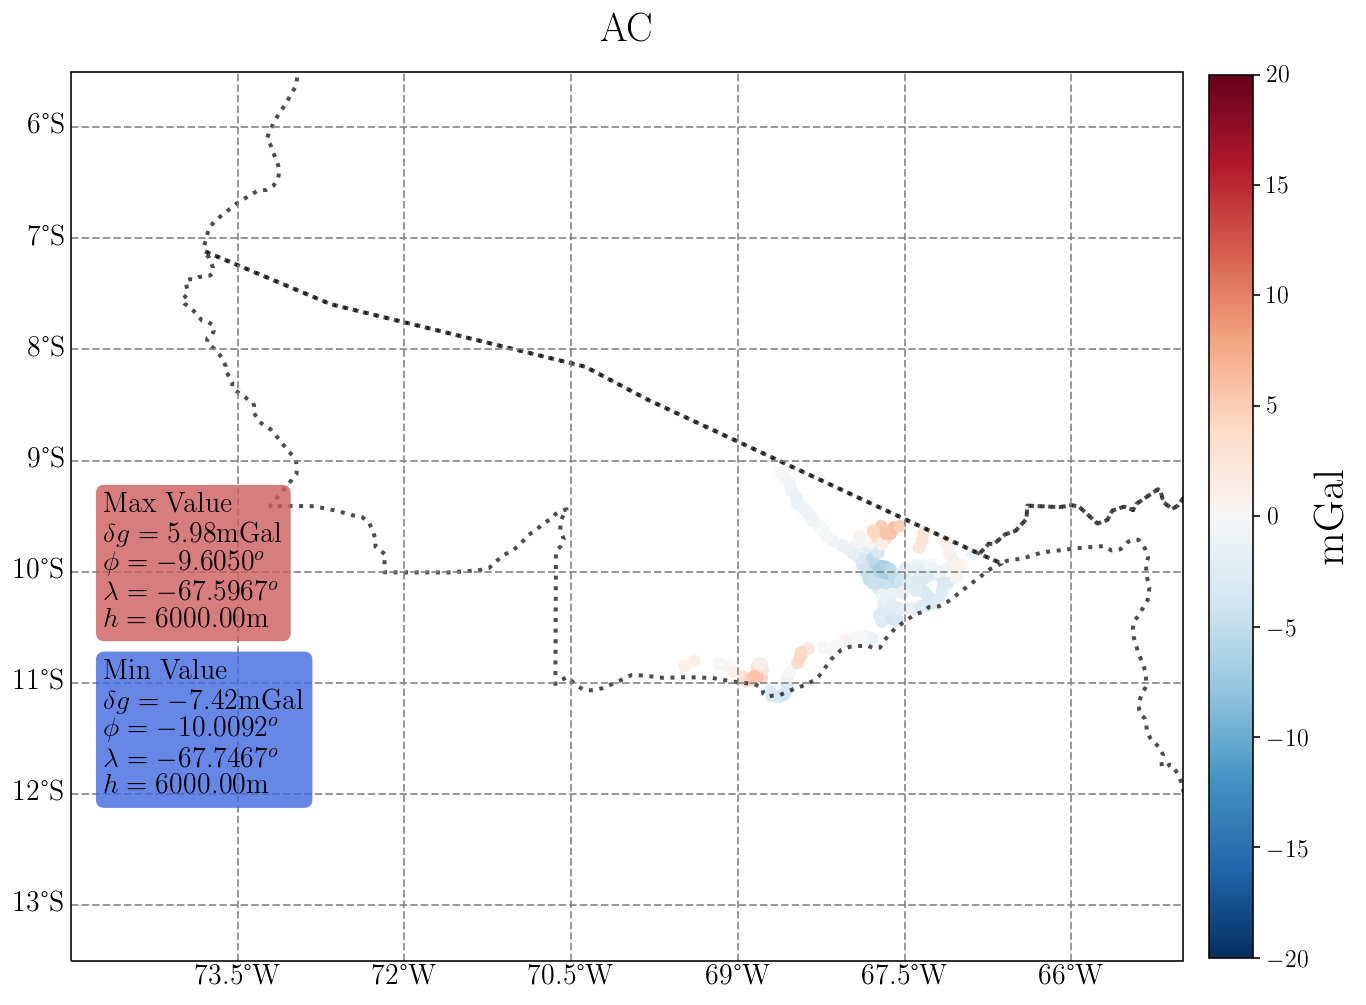

In [32]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(12.,14.), \
          region=[-75.,-65.,-13.5,-5.5], sign=(-74.7,-74.7,-10.5,-12), shrink=0.58, lim_val=(True, 20.))

In [33]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


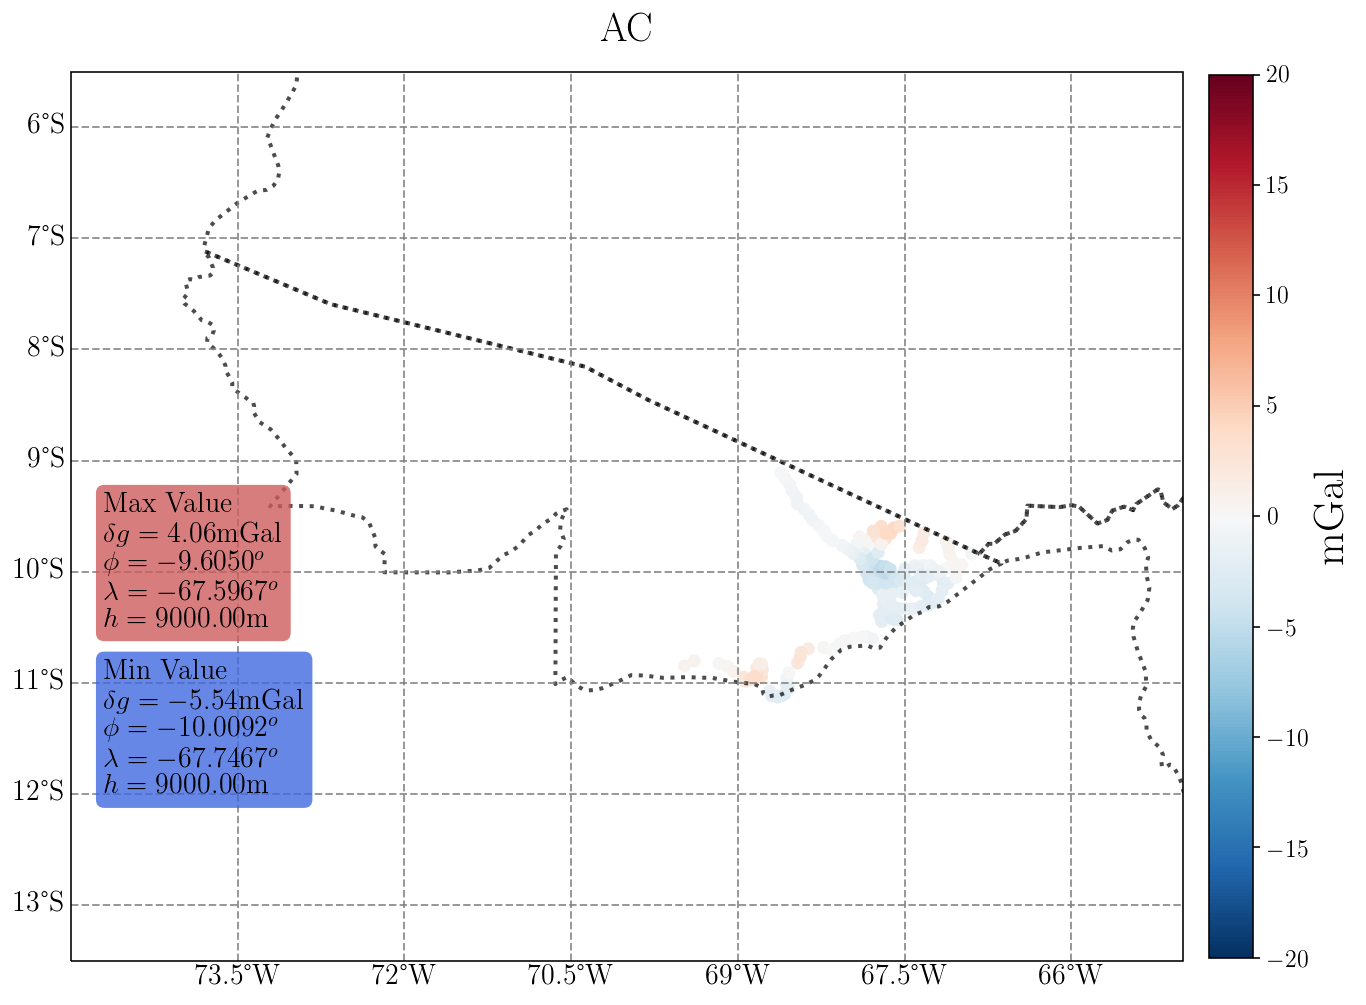

In [34]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(12.,14.), \
          region=[-75.,-65.,-13.5,-5.5], sign=(-74.7,-74.7,-10.5,-12), shrink=0.58, lim_val=(True, 20.))